Check if cuda is available, which is required to train the model on GPU.


In [14]:
import torch

print(torch.__version__)
print(torch.cuda.is_available())


2.4.1+cu124
True


In [ ]:
from fastai.vision.all import *
import pandas as pd
import re
import shutil
from pathlib import Path
from fastai.metrics import mse
from fastai.vision.all import *
from mss import mss
import numpy as np
import cv2
import time
import pygetwindow as gw
from vgamepad import VDS4Gamepad
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from gamepad_simulator import GamepadSimulator

# Regression model

### Data preperation
We start by preparing the data to be used during training. The data is stored with a timestamp and the joystick controls in the filename. This data is extracted from the filename and saved in a dataframe along with the filepath. We then place this data in a datblock. In the datablock we split the data to get both a training and a validation set. We also make all the sizes uniform and perform random augmentations to help the model become more robust. We do limit the intensity of the augmentations as the variation in the real-life data will also be limited.

In [1]:
path = Path("./screen_caps_edited")

# List all the image filenames in the folder
filenames = [f.name for f in path.ls() if f.name.endswith('.jpg')] 

# Extract controller values from filenames using regex
def extract_controller_values(file_name):
    pattern = r'(?P<timestamp>\d{8}_\d{6})_(?P<LX>[-0-9.]+)_(?P<LT>[-0-9.]+)_(?P<RT>[-0-9.]+)\.jpg$'
    match = re.search(pattern, file_name)
    if match:
        return int(match.group('timestamp')), float(match.group('LX')), float(match.group('LT')), float(match.group('RT'))
    else:
        print('NO MATCH FOUND')
        return None  

# Generate labels using the filenames
labels = [extract_controller_values(fn) for fn in filenames]

# Create a DataFrame to map filenames to their controller inputs
df = pd.DataFrame({
    'filename': filenames,
    'timestamp': [label[0] for label in labels],
    'LX': [label[1] for label in labels],
    'LT': [label[2] for label in labels],
    'RT': [label[3] for label in labels]
})

# Define the DataBlock for training a regression model
dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),  # Images as inputs and regression labels
    get_x=ColReader('filename', pref=path),  # Get the file path from the 'filename' column
    get_y=ColReader(['LX', 'LT', 'RT']),  # Get the controller values
    splitter=RandomSplitter(valid_pct=0.2),  # Split 80% for training, 20% for validation
    item_tfms=Resize(224),  # Resize images to 224x224 (adjust as needed)
    batch_tfms=aug_transforms(
        max_rotate=10,   # Small rotation (up to 10 degrees), mimicking slight steering adjustments
        max_zoom=1.1,    # Zoom in/out slightly to simulate different distances
        max_warp=0.2,    # Warp the image a bit to simulate perspective changes
        max_lighting=0.2,  # Adjust brightness and contrast
        p_affine=0.75,   # Probability of applying affine transforms (zoom, rotate, warp)
        p_lighting=0.75,  # Probability of applying lighting transforms
        do_flip=False,   # Disable horizontal flips since that would make left/right confusing
    )
)

# Create DataLoaders
dls = dblock.dataloaders(df, bs=64)

#### DO NOT RUN

The below code will make a copy of all data where the steering is either 75% to the left or 75% to the right. This code can be run to make the dataset more biased towards steering, as the model had difficulty learning this behavior on the original dataset.

In [5]:
# Create a new directory to store the copied images
output_dir = Path("./filtered_images")
output_dir.mkdir(exist_ok=True)

# Filter the DataFrame for images with LX > 0.75 or LX < -0.75
filtered_df = df[(df['LX'] > 0.75) | (df['LX'] < -0.75)]
# filtered_df = 
# Path to your source images
source_dir = Path("./screen_caps")

# Copy the filtered images to the new directory
for index, row in filtered_df.iterrows():
    source_file = source_dir / row['filename']

    timestamp, LX, LT, RT = extract_controller_values(row['filename'])
    timestamp = timestamp + 1000
    timestamp = str(timestamp)
    timestamp = f"{timestamp[:8]}_{timestamp[8:]}"
    destination_filename = f'{timestamp}_{round(LX,4)}_{round(LT,4)}_{round(RT,4)}.jpg'

    destination_file = output_dir / destination_filename
    
    # Copy the image
    shutil.copy(source_file, destination_file)

print(f"Copied {len(filtered_df)} images to {output_dir}")


Copied 2961 images to filtered_images


## Training the model
This is where the fun stuff happens. We take a pretrained ResNet50 CNN, with a mean square error loss function. We use 16-bit floating point precision and run the code on GPU if available. We then go through several cycles of finding the optimal maximum learning rate and using that to train the model using simulated annealing. 

c:\Users\Jeffr\Documents\School\IT\Deep Learning\CVC_challenge\CVC_challenge_env\Lib\site-packages\fastai\vision\learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
c:\Users\Jeffr\Documents\School\IT\Deep Learning\CVC_challenge\CVC_challenge_env\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
c:\Users\Jeffr\Documents\School\IT\Deep Learning\CVC_challenge\CVC_challenge_env\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.

c:\Users\Jeffr\Documents\School\IT\Deep Learning\CVC_challenge\CVC_challenge_env\Lib\site-packages\fastai\learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state 

SuggestedLRs(valley=0.0030199517495930195)

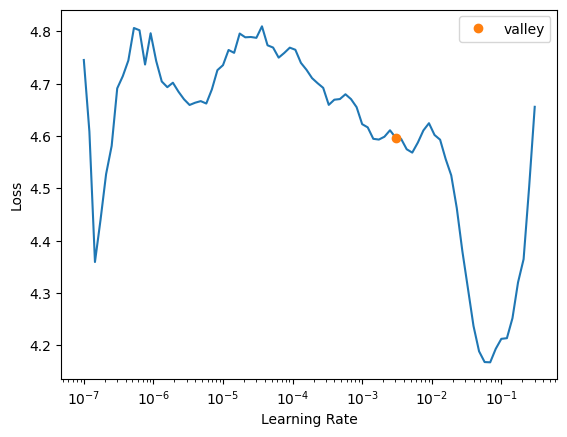

In [2]:
# Define the model 
learner = cnn_learner(dls, resnet50, loss_func=MSELossFlat(), metrics=[mse])

# Make sure the model is trained on GPU when available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
learner.model = learner.model.to(device) 

# Use fp16 
learner.to_fp16()

# Find the optimal learning rate
learner.lr_find()

c:\Users\Jeffr\Documents\School\IT\Deep Learning\CVC_challenge\CVC_challenge_env\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
c:\Users\Jeffr\Documents\School\IT\Deep Learning\CVC_challenge\CVC_challenge_env\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,mse,time
0,1.866695,0.662665,0.662665,03:41
1,0.566150,0.499185,0.499185,03:29
2,0.527026,0.481675,0.481675,03:29
3,0.473663,0.396208,0.396208,03:28
4,0.424035,0.378254,0.378254,03:28
5,0.386377,0.350977,0.350977,03:25
6,0.368273,0.313381,0.313381,03:23
7,0.342812,0.303412,0.303412,03:27
8,0.336182,0.296135,0.296135,03:25
9,0.332254,0.296954,0.296954,03:23


c:\Users\Jeffr\Documents\School\IT\Deep Learning\CVC_challenge\CVC_challenge_env\Lib\site-packages\fastai\learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state 

SuggestedLRs(valley=0.00015848931798245758)

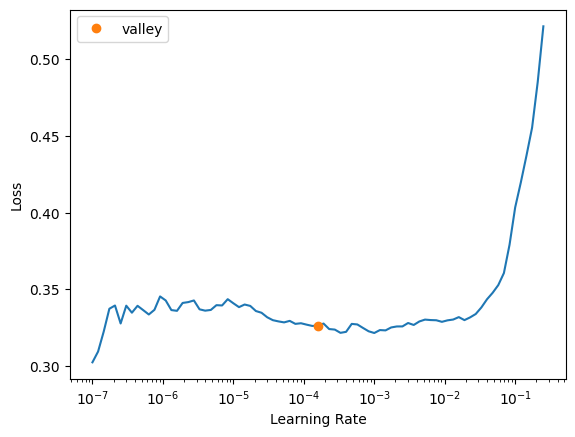

In [3]:
learner.fit_one_cycle(10, lr_max=3e-3)

learner.lr_find()


In [4]:
learner.fit_one_cycle(5, lr_max=1e-4)

c:\Users\Jeffr\Documents\School\IT\Deep Learning\CVC_challenge\CVC_challenge_env\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
c:\Users\Jeffr\Documents\School\IT\Deep Learning\CVC_challenge\CVC_challenge_env\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,mse,time
0,0.332919,0.297717,0.297717,03:24
1,0.324782,0.293365,0.293365,03:26
2,0.331845,0.293570,0.293570,03:24
3,0.329873,0.295464,0.295464,03:23
4,0.330545,0.295988,0.295988,03:28


c:\Users\Jeffr\Documents\School\IT\Deep Learning\CVC_challenge\CVC_challenge_env\Lib\site-packages\fastai\learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state 

SuggestedLRs(valley=0.001737800776027143)

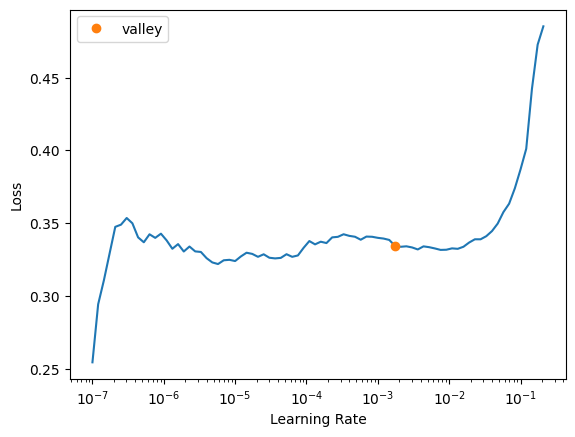

In [5]:
learner.lr_find()

c:\Users\Jeffr\Documents\School\IT\Deep Learning\CVC_challenge\CVC_challenge_env\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
c:\Users\Jeffr\Documents\School\IT\Deep Learning\CVC_challenge\CVC_challenge_env\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,mse,time
0,0.329416,0.294298,0.294298,03:36
1,0.337291,0.294127,0.294127,03:35
2,0.321079,0.286726,0.286726,03:11
3,0.321970,0.280904,0.280904,02:57
4,0.316378,0.280367,0.280367,03:05


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

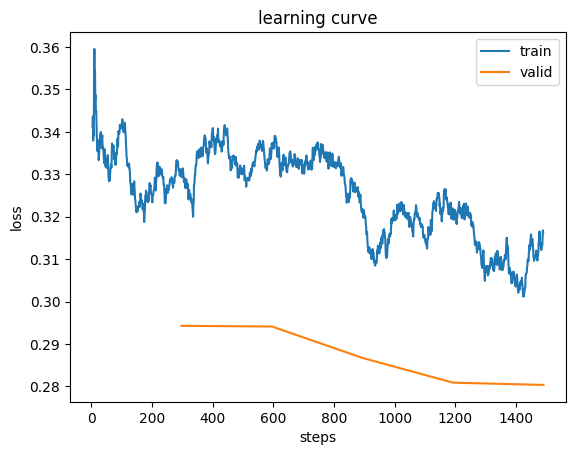

In [6]:
learner.fit_one_cycle(5, lr_max=1e-3)

learner.recorder.plot_loss()

c:\Users\Jeffr\Documents\School\IT\Deep Learning\CVC_challenge\CVC_challenge_env\Lib\site-packages\fastai\learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state 

SuggestedLRs(valley=0.0010000000474974513)

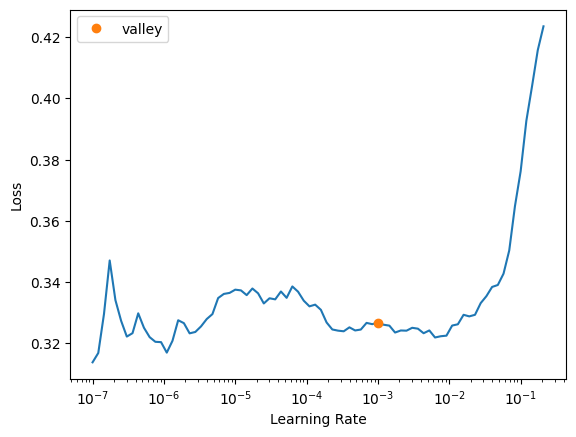

In [7]:
learner.lr_find()

In [8]:
learner.fit_one_cycle(5, lr_max=1e-3)

epoch,train_loss,valid_loss,mse,time
0,0.313911,0.285655,0.285655,03:24
1,0.318991,0.274912,0.274912,03:26
2,0.306041,0.272851,0.272851,03:26
3,0.298457,0.266201,0.266201,03:31
4,0.296165,0.266364,0.266364,03:30


SuggestedLRs(valley=0.00363078061491251)

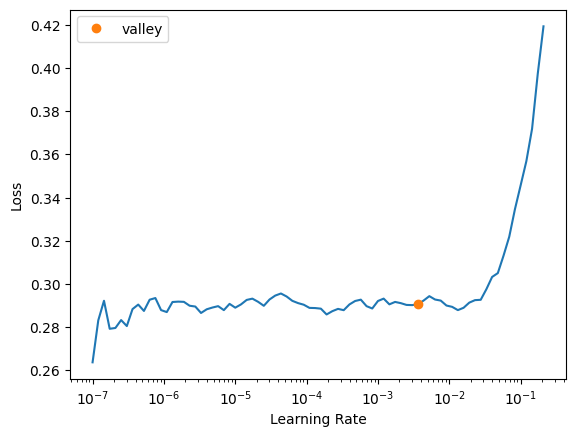

In [9]:
learner.lr_find()

In [10]:
# Unfreeze as soon as a plateau seems to be reached in training the model
learner.unfreeze()
learner.fit_one_cycle(5, lr_max=3e-3)

c:\Users\Jeffr\Documents\School\IT\Deep Learning\CVC_challenge\CVC_challenge_env\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
c:\Users\Jeffr\Documents\School\IT\Deep Learning\CVC_challenge\CVC_challenge_env\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,mse,time
0,0.410149,0.594125,0.594125,03:36
1,0.416055,0.394637,0.394637,03:36
2,0.373942,0.341068,0.341068,03:35
3,0.330298,0.304754,0.304754,03:37
4,0.298727,0.285159,0.285159,03:36


c:\Users\Jeffr\Documents\School\IT\Deep Learning\CVC_challenge\CVC_challenge_env\Lib\site-packages\fastai\learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state 

SuggestedLRs(valley=0.0008317637839354575)

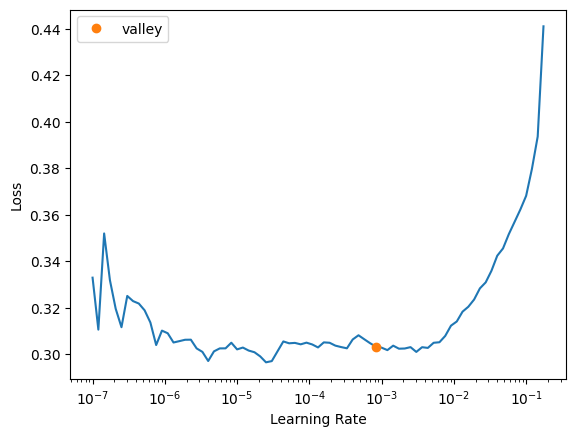

In [11]:
learner.lr_find()

In [12]:
learner.fit_one_cycle(5, lr_max=8e-4)

c:\Users\Jeffr\Documents\School\IT\Deep Learning\CVC_challenge\CVC_challenge_env\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
c:\Users\Jeffr\Documents\School\IT\Deep Learning\CVC_challenge\CVC_challenge_env\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,mse,time
0,0.303533,0.310426,0.310426,03:31
1,0.316735,0.304210,0.304210,03:36
2,0.285598,0.275657,0.275657,03:35
3,0.271073,0.249528,0.249528,03:38
4,0.261588,0.248697,0.248697,03:35


c:\Users\Jeffr\Documents\School\IT\Deep Learning\CVC_challenge\CVC_challenge_env\Lib\site-packages\fastai\learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state 

SuggestedLRs(valley=0.0003981071640737355)

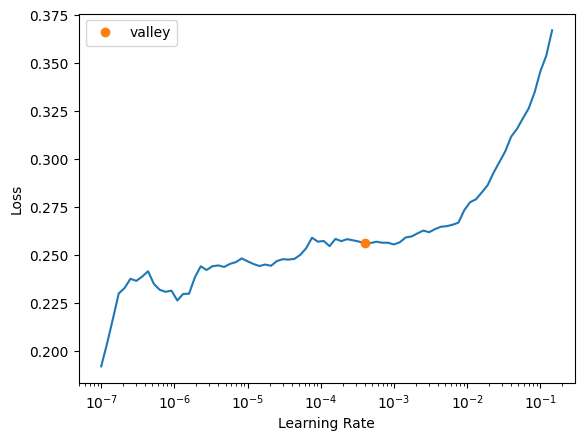

In [13]:
learner.lr_find()

In [14]:
learner.fit_one_cycle(5, lr_max=4e-4)

c:\Users\Jeffr\Documents\School\IT\Deep Learning\CVC_challenge\CVC_challenge_env\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
c:\Users\Jeffr\Documents\School\IT\Deep Learning\CVC_challenge\CVC_challenge_env\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,mse,time
0,0.259777,0.249490,0.249490,03:41
1,0.262778,0.255153,0.255153,03:28
2,0.253989,0.235727,0.235727,03:11
3,0.236626,0.226852,0.226852,03:10
4,0.233307,0.228203,0.228203,03:11


In [15]:
learner.save('model')

Path('models/model.pth')

## Drive
The below code is used to both make predictions based on the model and then use those predictions to play the game

In [ ]:
def load_model():
    """Load the trained regression model"""
    # Since you're using a regression model, remove the accuracy metric
    learner = cnn_learner(dls, resnet50, loss_func=MSELossFlat())
    learner.load('model')  # Load the saved model
    return learner

def drive_game(learner, screen_capture, gamepad_simulator, duration=60):
    """Use the model to predict actions and simulate gamepad inputs"""
    start_time = time.time()
    gamepad_simulator.reset()

    while time.time() - start_time < duration:
        # Capture the game screen
        frame = screen_capture.capture_frame()
        frame = screen_capture.resize_frame(frame)
        
        # Convert the frame to a PIL image
        pil_img = PILImage.create(frame)
        if pil_img.mode == 'RGBA':
            pil_img = pil_img.convert('RGB')
        
        # Predict the controller inputs (LX, LT, RT) using the trained model
        pred = learner.predict(pil_img)[0] 
        
        # Extract the predicted LX, LT, RT values from the prediction
        lx, lt, rt = pred

        # Simulate the controller inputs based on the prediction
        gamepad_simulator.set_input(lx, lt, rt)
        
        # Uncomment to print the predicted values for debugging
        # print(f"Predicted LX: {lx}, LT: {lt}, RT: {rt}")
        
        # Sleep for a short period to control the simulation speed
        time.sleep(0.1)

    gamepad_simulator.reset()


# Initialize components
time.sleep(5)
print('start')
screen_capture = ScreenCapture()
gamepad_simulator = GamepadSimulator()
print(gamepad_simulator.gamepad)
learner = load_model()

# Start driving the game for the given duration
drive_game(learner, screen_capture, gamepad_simulator, duration=30)


: 